In [1]:
from IPython.core.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

<center><img src="Main Photo.png"/></center>

<center><img src="Title.png"/></center>

In [2]:
# For data prep
import requests
import re
import numpy as np
import pandas as pd
import sqlite3
from sqlalchemy import create_engine

# For writeup
from textwrap import wrap
from IPython.display import HTML
from IPython.core.display import HTML as Center
import warnings
warnings.filterwarnings('ignore')

# For 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter

# Custom plot format
plt.rcParams['figure.figsize'] = 16,6
plt.rcParams['lines.linewidth'] = 3.5
plt.rcParams['figure.titlesize'] = 32

custom_sns_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme('notebook', style='ticks', font_scale=1.5, rc=custom_sns_params)
colors = ['#393357', '#FFD400', '#00A5D3', '#009A57', '#6E3476']
custom_palette = sns.blend_palette(colors, n_colors=8)
sns.set_palette(custom_palette)

In [3]:
def return_sim_books(title_id, title_matrix, vectorizer, top_n = 10):
    
    # generate sim matrix
    sim_matrix = cosine_similarity(title_matrix, title_matrix)
    features = vectorizer.get_feature_names_out()

    top_n_idx = np.flip(np.argsort(sim_matrix[title_id,]),axis=0)[0:top_n]
    top_n_sim_values = sim_matrix[title_id, top_n_idx]
    
    # find top n with values > 0
    top_n_idx = top_n_idx[top_n_sim_values > 0]
    scores = top_n_sim_values[top_n_sim_values > 0]

    
    
    # find features from the vectorized matrix
    sim_books_idx = books_title['title'].iloc[top_n_idx].index
    words = []
    for book_idx in sim_books_idx:
        try:
            feature_array = np.squeeze(title_matrix[book_idx,].toarray())
        except:
            feature_array = np.squeeze(title_matrix[book_idx,])
        idx = np.where(feature_array > 0)
        words.append([" , ".join([features[i] for i in idx[0]])])
        
    # collate results
    res = pd.DataFrame({"book_title" : books_title['title'].iloc[title_id],
                        "sim_books": books_title['title'].iloc[top_n_idx].values,
                        "author": books_title['author'].iloc[top_n_idx].values,
                        "words": words,
                        "scores": scores,
                        "book_image":books_title['book_image'].iloc[top_n_idx].values},
                        columns = ["book_title","sim_books","author","scores","words", "book_image"])
    
    return res


In [4]:
engine = create_engine('sqlite:////mnt/processed/private/msds2023/lt9/nytbooks.db')
# engine = create_engine('sqlite:///nytbooks.db')
df_books_raw = pd.read_sql_table('gen_df', engine)

df_books = df_books_raw[['author',
                         'book_image',
                         'publisher',
                         'title',
                         'description',]]
df_books = df_books.loc[df_books['author'].isna() == False]
df_books = df_books.loc[df_books['book_image'].isna() == False]
df_books = df_books.drop_duplicates(subset=['book_image'])

books_title = df_books.copy()
books_title = books_title.reset_index().drop('index', axis=1)
books_title.loc[books_title['description'].isna(), 'description'] = ''

<h1 style="color:#000000">I. Executive Summary</h1>

<span style="font-size: 20px">
    A <b>'book hangover'</b> is typically a common phenomenon that book lovers feel especially when they have read an especially good and relatable book (mostly fiction). It is a phenomenon that conjures the sadness and melancholy feelings of a reader, which if not treated immediately, may at worst affect an individual's way of life for a short period of time. A solution to mitigate this feeling is to veer the reader away from the previously read book that triggered the hangover -- by recommending the next book based on it.
    <p>&nbsp;</p>
    <b> The goal of this system is to recommend the next top 5 books based from the previously read book in order to help the affected reader to relieve him or herself from going deep into the book hangover.</b>
    <p>&nbsp;</p>
    The team had developed this <b>Book Recommender System</b> based on the database taken from the `New York Times - Books API`. There are three(3) ways for a reader to search for the top 5 recommended books:
    <ol>
        <li>Content-Based Recommender System;</li>&nbsp;  
        <li>Description-Based Recommender System; and</li>&nbsp;  
        <li>Author-Based Recommender System.</li>&nbsp;  
    </ol>
    <p>&nbsp;</p>
    In each way, the <b>COUNT VECTORIZER</b> and <b>TF-IDF VECTORIZER</b> were used to extract the <b>Top 5 Recommended Books</b>.
    <p>&nbsp;</p>
    After developing this system, the team found that the TF-IDF is in general better than Count Vectorizers because it not only focuses on the frequency of words present in the corpus but also provides the importance of the words. We can then remove the words that are less important for analysis, hence making the model building less complex by reducing the input dimensions.
</span>
    

<h1 style="color:#000000">II. Problem Statement</h1>

<center><img src="How_to_.png"/></center>

<span style="font-size: 20px">How to get over a book hangover? Don't know what to read next? To relieve a reader from the empty void feeling after finishing a book - <b>this <u>Book Recommender System</u> aims to present the next top 5 books to read based on a previously read book.</b></span>

<h1 style="color:#000000">III. Motivation</h1>

<span style="font-size: 20px">According to an author from bookriot.com: <blockquote><span style="font-size: 18px"><i>"A <b>'book hangover'</b> is the slangy shortcut for the feeling when a reader finishes a book—usually fiction—and they can’t stop thinking about the fictional world that has run out of pages. The story is over, but the reader misses the characters or the atmosphere of the novel."<sup>1</sup></i></span></blockquote></span>

<p>&nbsp;</p>

<span style="font-size: 20px">It is a common phenomenon that the feeling of emptiness consumes bookworms after reading an especially good book. The feeling of sadness or separation anxiety could get worse to the point that it affects the reader's way of living for a short period. Of course, this is not something that anyone would want to happen. One way to get over a book hangover is to search for books similar to one that is previously read. It veers the reader slightly away from the world of the previous book, but not separated from it that the reader would deem it as something not worth reading. It must be similar to the previous one and at the same time fills in the void of that empty feeling.</span>
    
<p>&nbsp;</p>

<span style="font-size: 20px">A reader does not have to feel so empty after finishing a good book after all. Hence, this Book Recommender system aims to present the next top 5 books based on a previously read book - to ultimately fill the void of a book hangover.</span>

<h1 style="color:#000000">IV. Data Source</h1>

<center><img src="nytbanner.png"/></center>

<p>&nbsp;</p>
<span style="font-size: 20px"><b>New York Times (NYT)</b> currently has ten public APIs: Archive, Article Search, Books, Most Popular, Semantic, Times Newswire, TimesTags, and Top Stories. These public APIs are designed for the web developer community, but non-commercial users are also welcome to use it.</span>

<p>&nbsp;</p>

<span style="font-size: 20px"><u>NYT has cited two reasons why they are offering their APIs to the public:</u></span>
<ol>
    <span style="font-size: 20px">
    <li>Encourage innovation through collaboration by building applications and mashups that would reveal the potential of their data;</li></span>&nbsp;  
<span style="font-size: 20px">
    <li>Journalism: to inform the public and fulfill their newspaper's journalistic mission by putting more information in the hands of the public and to enable better storytelling.</li></span>
    </ol>
    
<p>&nbsp;</p>

<span style="font-size: 20px">
NYT APIs use a RESTful style and a resource-oriented architecture where calls are made via HTTPS requests. Sample requests are provided for in the website with complete and concise API documentation. API calls should always include the API key within the query string.
<p>&nbsp;</p>

<b>The New York Times Books data used in this study was extracted from the `New York Times Books API`,</b> which provides information about <u>book reviews and the NYT best seller list</u>. The API paths included in the Books API returns a list of <u>best sellers, full overview, names, and reviews.</u>
</span><p>&nbsp;</p>

<center><span style="font-size: 20px"><b>New York Times Public APIs</b></span></center>&nbsp; 
<center><img src="NTY_APIs.png"/></center>

<center><h3 style="color:#000000"><u>Raw Data Description</u></h3></center>

<center><span style="font-size: 20px">
This dataset contains the details of New York Times Best Selling Books from 2008 until 2022.
</span></center>

<span style="font-size: 16px">
    <center><b>Table 1. New York Times Best Selling Books Raw Data Description</b></center>
</span>
    
|<center>Variable Name</center>|<center>Data type</center>|<center>Variable category</center>|<center>Description</center>
|:---|:---|:---|:---|
|age_group|character|categorical|Age group
|amazon_product_url|character|categorical|Amazon product url
|article_chapter_link|character|categorical|Chapter link of article
|author|character|categorical|Book Author
|book_image|character|categorical|Book cover image url
|book_image_width|numerical|continuous| Book image width
|book_image_height|numerical|continuous|Book image height
|book_review_link|character|categorical|Book review url
|contributor|character|categorical|Book contributors
|contributor_note|character|categorical|Book contributor notes
|created_date|character|categorical|Date created
|description|character|categorical|Book description
|first_chapter_link|character|categorical|First chapter url
|price|numerical|continuous|Price of book
|primary_isbn10|character|categorical|10-digit isbn
|primary_isbn13|character|categorical|13-digit isbn
|book_uri|character|categorical|Book URI
|publisher|character|categorical|Book publisher
|ranks|numerical|discrete|Ranking during publication of rank list
|ranks_last_week|numerical|discrete|Previous week ranking
|sunday_review_link|character|categorical| Sunday review url
|title|character|categorical|Book title
|updated_date|character|categorical|Date updated
|weeks_on_list|numerical|discrete|Duration on best selling list
|buy_links|character|categorical|List of buy links
|list_id|numerical|discrete|List or category id



<center><h3 style="color:#000000"><u>Final Data Description</u></h3></center>

<span style="font-size: 16px">
    <center><b>Table 2. New York Times Best Selling Books Final Data Description</b></center>
</span>

|<center>Variable Name</center>|<center>Data type</center>|<center>Variable category</center>|<center>Description</center>
|:---|:---|:---|:---|
|author|character|categorical|Book Author
|book_image|character|categorical|Book cover image url
|publisher|character|categorical|Book publisher
|title|character|categorical|Book title
|description|character|categorical|Book description


<h1 style="color:#000000">V. Data Exploration</h1>

<span style="font-size: 18px">
    <b>Table 3. New York Times Best Selling Books from Raw Data</b>
</span>

In [5]:
df_books_raw.head()

age_group                                 amazon_product_url  \
0      None  http://www.amazon.com/Odd-Hours-Dean-Koontz/dp...   
1      None  http://www.amazon.com/The-Host-Novel-Stephenie...   
2      None  http://www.amazon.com/Love-Youre-With-Emily-Gi...   
3      None  http://www.amazon.com/The-Front-Garano-Patrici...   
4      None  http://www.amazon.com/Snuff-Chuck-Palahniuk/dp...   

  article_chapter_link             author  \
0                 None      Dean R Koontz   
1                 None    Stephenie Meyer   
2                 None       Emily Giffin   
3                 None  Patricia Cornwell   
4                 None    Chuck Palahniuk   

                                          book_image  book_image_width  \
0  https://storage.googleapis.com/du-prd/books/im...             313.0   
1  https://storage.googleapis.com/du-prd/books/im...             326.0   
2  https://storage.googleapis.com/du-prd/books/im...             185.0   
3  https://storage.googleapis.com/du-prd/books/im...             310.0   
4  https://storage.googleapis.com/du-prd/books/im...             327.0   

   book_image_height book_review_link           contributor contributor_note  \
0              495.0             None     by Dean R. Koontz             None   
1              495.0             None    by Stephenie Meyer             None   
2              276.0             None       by Emily Giffin             None   
3              495.0             None  by Patricia Cornwell             None   
4              495.0             None    by Chuck Palahniuk             None   

   ...                                         book_uri      publisher rank  \
0  ...  nyt://book/e165db0c-ce98-5193-aeba-1f688614dda7         Bantam    1   
1  ...  nyt://book/10496448-fe0f-5eeb-828c-077e99eb8ee8  Little, Brown    2   
2  ...  nyt://book/4294cfc8-5ded-5a20-ae4c-8408bdfd4bb8   St. Martin's    3   
3  ...  nyt://book/de8fbc6a-eb6d-5dac-bb59-b6bac358abee         Putnam    4   
4  ...  nyt://book/6a2cf5c4-984a-5230-a168-183d1c40d3b6      Doubleday    5   

   rank_last_week                                 sunday_review_link  \
0               0                                               None   
1               1                                               None   
2               2                                               None   
3               0                                               None   
4               0  https://www.nytimes.com/2008/06/08/books/revie...   

                      title         updated_date weeks_on_list  \
0                 ODD HOURS  2011-03-09 15:47:58             1   
1                  THE HOST  2011-03-09 15:47:58             3   
2  LOVE THE ONE YOU'RE WITH  2011-03-09 15:47:58             2   
3                 THE FRONT  2011-03-09 15:47:58             1   
4                     SNUFF  2011-03-09 15:47:58             1   

                                           buy_links  list_id  
0  [{'name': 'Amazon', 'url': 'http://www.amazon....        1  
1  [{'name': 'Amazon', 'url': 'http://www.amazon....        1  
2  [{'name': 'Amazon', 'url': 'http://www.amazon....        1  
3  [{'name': 'Amazon', 'url': 'http://www.amazon....        1  
4  [{'name': 'Amazon', 'url': 'http://www.amazon....        1  

[5 rows x 26 columns]

<span style="font-size: 18px">
    <b>Table 4. New York Times Best Selling Books Raw Data Summary</b>
</span>

In [6]:
data = [{'No. of Titles':len(df_books_raw['title'].unique()),'No. of Authors':len(df_books_raw['author'].unique()),
        'No. of Publishers':len(df_books_raw['publisher'].unique()),'Dataset Shape':df_books_raw.shape[0]}]
# data = [len(df_books_raw['title'].unique()),len(df_books_raw['author'].unique()),len(df_books_raw['publisher'].unique())]
df_books_raw_summary = pd.DataFrame.from_dict(data)
df_books_raw_summary

No. of Titles  No. of Authors  No. of Publishers  Dataset Shape
0           8396            4488               1061          79836

<span style="font-size: 18px">
    <b>Dataset Information</b>
</span>

In [7]:
df_books_raw.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79836 entries, 0 to 79835
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age_group             3729 non-null   object 
 1   amazon_product_url    79836 non-null  object 
 2   article_chapter_link  1155 non-null   object 
 3   author                79766 non-null  object 
 4   book_image            79823 non-null  object 
 5   book_image_width      79823 non-null  float64
 6   book_image_height     79823 non-null  float64
 7   book_review_link      14188 non-null  object 
 8   contributor           79781 non-null  object 
 9   contributor_note      5304 non-null   object 
 10  created_date          79836 non-null  object 
 11  description           68743 non-null  object 
 12  first_chapter_link    1176 non-null   object 
 13  price                 79836 non-null  float64
 14  primary_isbn10        77506 non-null  object 
 15  primary_isbn13     

<span style="font-size: 18px">
    <b>Graph 1. Distrbution of Book Prices</b> The Average Book Price in the NYT Best Seller Books is <b>$18.88</b>.
</span>

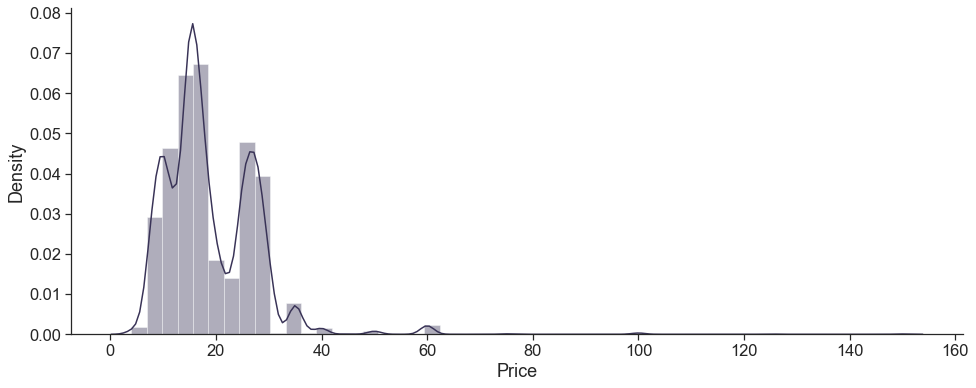

In [8]:
price_books = df_books_raw[df_books_raw['price']> 0]
Ave_book_price = price_books.price.mean()
sns.distplot(price_books['price'], kde=True)
# plt.suptitle('Distribution of Book prices', fontsize=15)
plt.xlabel('Price')
plt.show()

<span style="font-size: 18px">
    <b>Graph 2. Top 10 Longest Best Selling Books.</b> Diary of a Wimpy Kid BEATS Harry Potter (Shocking!).
</span>

<center><img src="diary.jpeg"/></center>

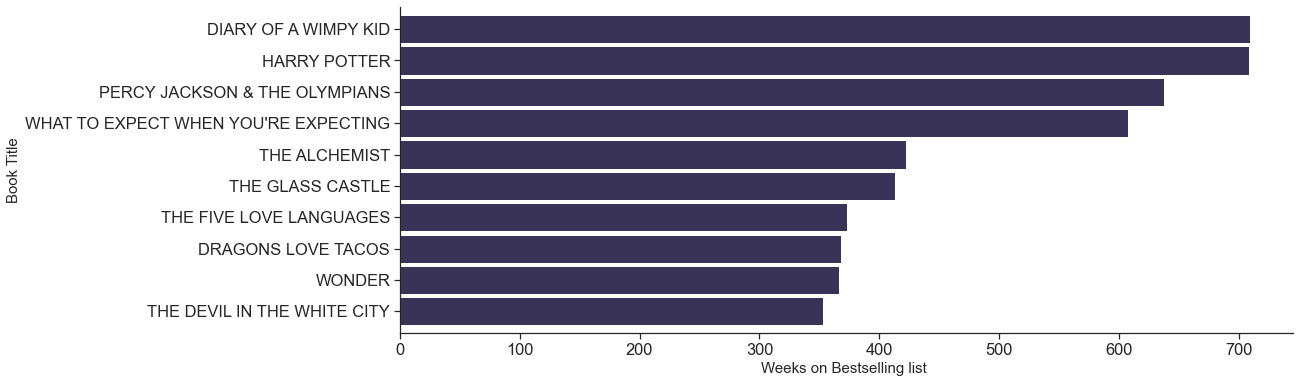

In [9]:
longest_bestsellers = df_books_raw[['title', 'weeks_on_list']].groupby('title').max().sort_values('weeks_on_list',
                                                                                                  ascending = False).head(10)
ax = longest_bestsellers['weeks_on_list'].sort_values().plot.barh(width=0.9)
ax.set_xlabel("Weeks on Bestselling list ", fontsize=15)
ax.set_ylabel("Book Title", fontsize=15)
# ax.set_title("Top 10 Best Selling Books",fontsize=20,color='black')
plt.show()

<span style="font-size: 18px">
    <b>Graph 3. Top 10 Highly Ranked Authors.</b> EL James author of the Fifty Shades of Grey Series made it to the top 10.
</span>

<center><img src="Fifty-Shades.jpeg"/></center>

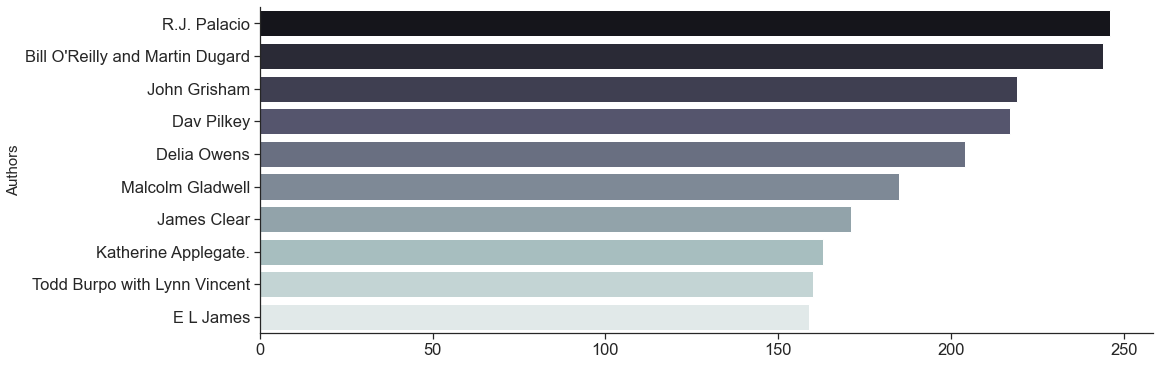

In [10]:
palette = sns.color_palette("bone", 10)
high_rank = df_books_raw[df_books_raw['rank'] == 1]
high_ranked = high_rank.value_counts('author').head(10)
rank = high_ranked.argsort().argsort()
ax = sns.barplot(y=high_ranked.index, x=high_ranked, palette=palette)
ax.set_xlabel("", fontsize=15)
ax.set_ylabel("Authors", fontsize=15)
# ax.set_title("Top 10 Highly Ranked Authors",fontsize=20,color='black')
plt.show()

<span style="font-size: 18px">
    <b>Graph 4. Top 10 Authors with Most Books.</b> Of Course John Green made it to the top 10.
</span>

<center><img src="John Green.png"/></center>

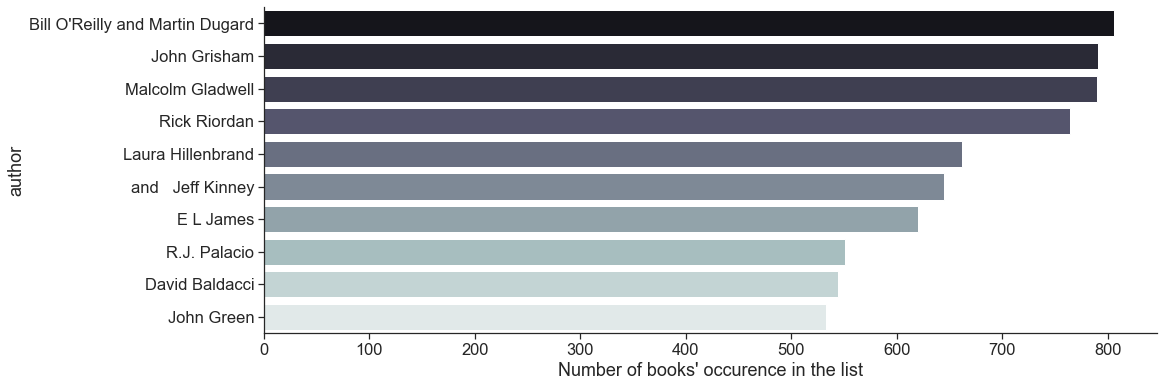

In [11]:
most_books = df_books_raw.groupby('author')['title'].count().reset_index().sort_values('title', 
                                                    ascending=False).head(10).set_index('author')

ax = sns.barplot(most_books['title'], most_books.index, palette=palette)
# ax.set_title("Top 10 authors with most books ")
ax.set_xlabel("Number of books' occurence in the list")

plt.show()

<span style="font-size: 18px">
    <b>Graph 5. Top 10 Publishers in NYT Best Sellers.</b>
</span>

<center><img src="Little.png"/></center>

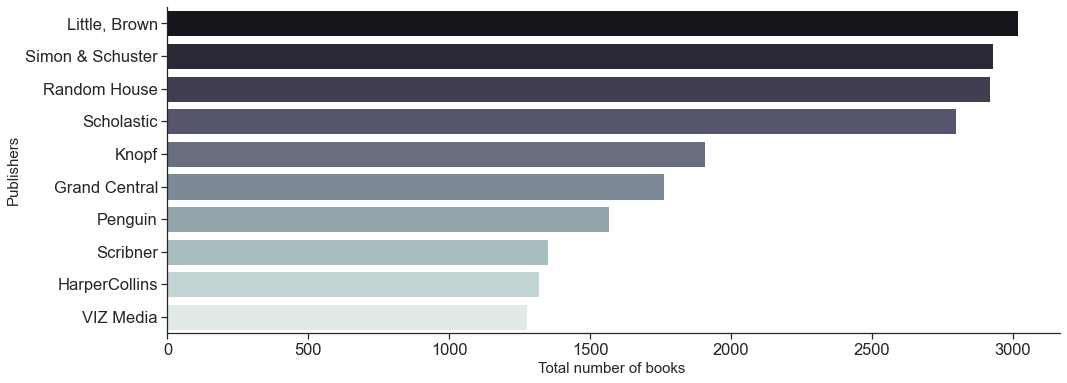

In [12]:
publisher = df_books_raw.value_counts('publisher').sort_values(ascending=False).head(10)
ax = sns.barplot(y=publisher.index,x = publisher, palette=palette)
ax.set_xlabel("Total number of books ", fontsize=15)
ax.set_ylabel("Publishers", fontsize=15)
# ax.set_title("Top 10 Publishers in NYT Best Sellers",fontsize=20,color='black')
plt.show()

<span style="font-size: 18px">
    <b>Graph 6. Distribution of Books by Age Group.</b> Highest number of books are mostly catered to young children to teenagers
</span>

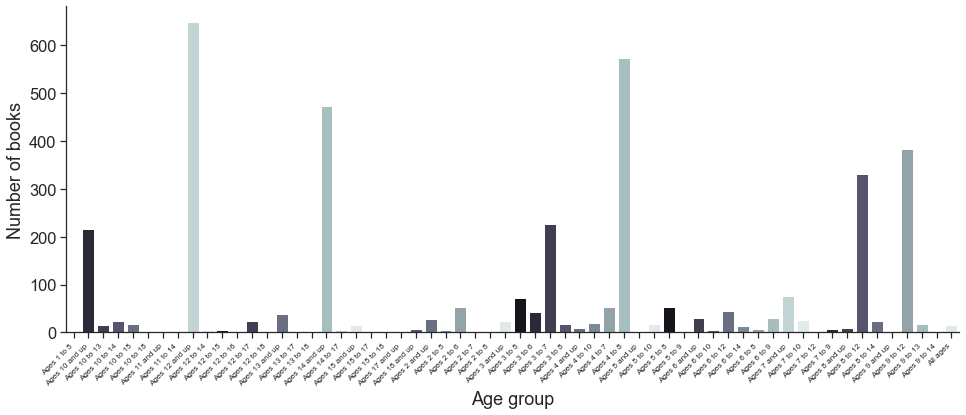

In [13]:
age_books = df_books_raw.groupby(['age_group'])['title'].count().sort_values(ascending=False).reset_index()
age_books = age_books.sort_values('age_group')
sns.barplot(data=age_books, x='age_group', y='title', palette=palette)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.xlabel('Age group')
plt.ylabel('Number of books')
# plt.title("Distribution of books by age group")
plt.show()

<span style="font-size: 18px">
    <b>Graph 7. Number of Books Published Every Year in the List of NYT Best Sellers.</b>
</span>

In [14]:
df_books_raw_new = df_books_raw.copy()
df_books_raw_new["created_date"] = df_books_raw_new["created_date"].str.split(' ', expand=True)[0]
df_books_raw_new["created_date"] = pd.to_datetime(df_books_raw_new["created_date"])
df_books_raw_new["created_year"] = df_books_raw_new["created_date"].dt.year

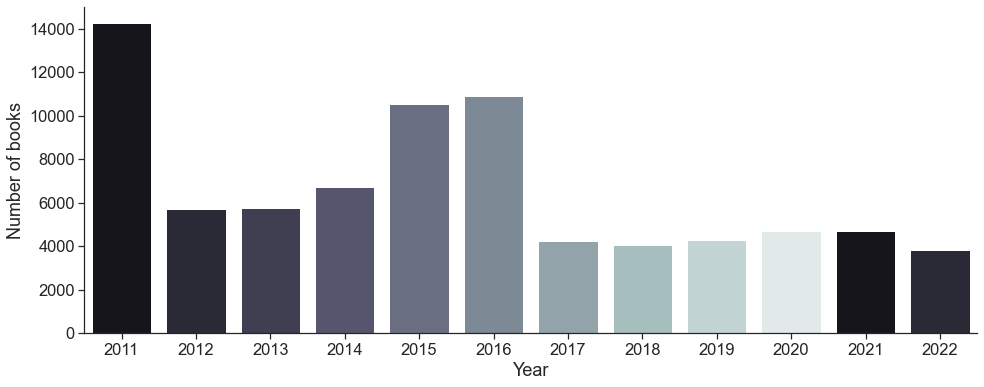

In [15]:
year_created = df_books_raw_new.groupby(['created_year'])['title'].count().reset_index()
year_created = year_created.sort_values('created_year')
sns.barplot(data=year_created, x='created_year', y='title', palette=palette)
plt.xticks()
plt.xlabel('Year')
plt.ylabel('Number of books')
# plt.title("Years books joined the NYT list") # tama ba ito meaning ng created_date?
plt.show()

<span style="font-size: 20px">
    <center><b>Word Cloud from the Titles of NYT Best Selling Books</b></center>
</span>

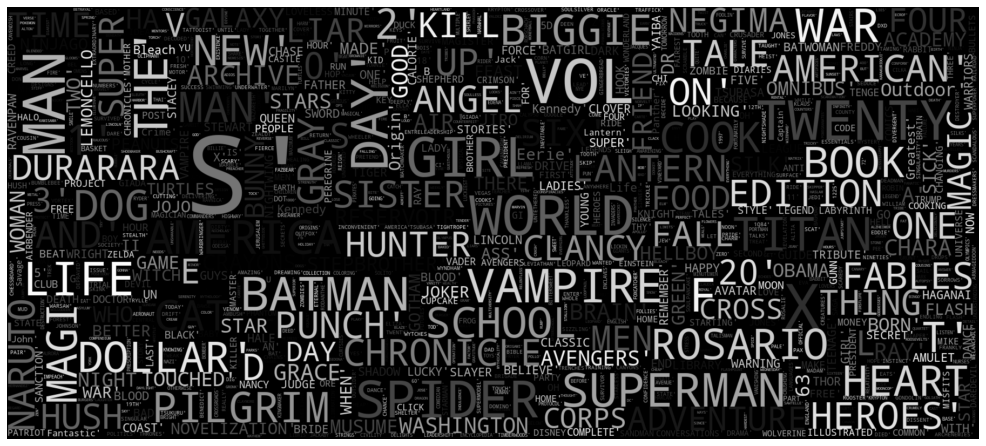

In [16]:
words=list(df_books_raw['title'])
gen=[]

for i in words:
    i=list(i.split(' '))
    for j in i:
        gen.append(j.replace(' ',""))
g=Counter(gen)

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

text = list(set(gen))
wordcloud = WordCloud(width=1800,height=800, max_font_size=200, max_words=1000,background_color="black",
                     colormap='gray', collocations=False, stopwords = STOPWORDS).generate(str(text))

plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

<h1 style="color:#000000">VI. Methodology</h1>

<center><img src="Methodology.png"/></center>

<p>&nbsp;</p>
<span style="font-size: 20px"><b>There are three (3) ways to search for the recommended books:</b>
<ol>
    <span style="font-size: 20px">
        <li>Content Based Recommender System</li>&nbsp;  
        <li>Description Based Recommender System</li>&nbsp;
        <li>Author Based Recommender System</li>&nbsp;
    </span>
</ol>
    
<span style="font-size: 20px">In each way, the <b>COUNT VECTORIZER</b> and <b>TF-IDF VECTORIZER</b> were used to extract the <b>Top 5 Recommended Books</b> based on a previously read book.</span>

<h2 style="color:#000000">1. Content Based Recommender System</h2>

<h3 style="color:#000000"><u>Count Vectorizer</u></h3>

In [17]:
vect = CountVectorizer(analyzer='word',ngram_range=(1,2),stop_words='english', min_df = 0.001)
vect.fit(books_title['title'])
title_matrix = vect.transform(books_title['title'])
print(books_title['title'][5274])
recom_books = return_sim_books(5274,title_matrix,vect,top_n=5)
display(recom_books)

STAR WARS: PRINCESS LEIA


book_title                      sim_books  \
0  STAR WARS: PRINCESS LEIA       STAR WARS: PRINCESS LEIA   
1  STAR WARS: PRINCESS LEIA   STAR WARS: A TEST OF COURAGE   
2  STAR WARS: PRINCESS LEIA  STAR WARS: OBI–WAN AND ANAKIN   
3  STAR WARS: PRINCESS LEIA       STAR WARS: THE LAST JEDI   
4  STAR WARS: PRINCESS LEIA             STAR WARS: PADAWAN   

                               author    scores  \
0          Mark Waid and Terry Dodson  1.000000   
1                     Justina Ireland  0.866025   
2  Charles Soule and Marco Checchetto  0.866025   
3                           Jason Fry  0.866025   
4                      Kiersten White  0.866025   

                                  words  \
0  [princess , star , star wars , wars]   
1             [star , star wars , wars]   
2             [star , star wars , wars]   
3             [star , star wars , wars]   
4             [star , star wars , wars]   

                                          book_image  
0  https://storage.googleapis.com/du-prd/books/im...  
1  https://storage.googleapis.com/du-prd/books/im...  
2  https://storage.googleapis.com/du-prd/books/im...  
3  https://storage.googleapis.com/du-prd/books/im...  
4  https://storage.googleapis.com/du-prd/books/im...

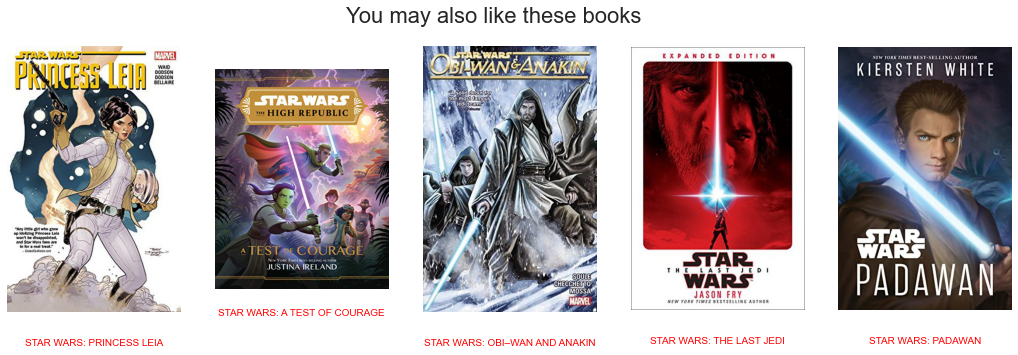

In [18]:
fig, axs = plt.subplots(1, 5,figsize=(18,5))
fig.suptitle('You may also like these books', size = 22)

for i, url in enumerate(recom_books['book_image']):
    im = Image.open(requests.get(url, stream=True).raw)
    axs[i].imshow(im)
    axs[i].axis("off")
    axs[i].set_title("\n".join(wrap(recom_books['sim_books'][i], 30)), y=-0.15, color='red', fontsize=10)
    fig.show()

<h3 style="color:#000000"><u>TF-IDF Vectorize</u></h3>

In [19]:
tf = TfidfVectorizer(analyzer = 'word', ngram_range = (1,2), min_df = 0.001, stop_words = 'english')
tf.fit(books_title['title'])
title_matrix_tf = tf.transform(books_title['title'])
print(books_title['title'][5274])
recom_tf = return_sim_books(5274,title_matrix_tf,tf,top_n=5)
display(recom_tf)

STAR WARS: PRINCESS LEIA


book_title                 sim_books  \
0  STAR WARS: PRINCESS LEIA  STAR WARS: PRINCESS LEIA   
1  STAR WARS: PRINCESS LEIA         STAR WARS: AHSOKA   
2  STAR WARS: PRINCESS LEIA             THE STAR WARS   
3  STAR WARS: PRINCESS LEIA      STAR WARS: AFTERMATH   
4  STAR WARS: PRINCESS LEIA  STAR WARS: THE LAST JEDI   

                        author    scores  \
0   Mark Waid and Terry Dodson  1.000000   
1                 E K Johnston  0.833082   
2  J W Rinzler and Mike Mayhew  0.833082   
3                 Chuck Wendig  0.833082   
4                    Jason Fry  0.833082   

                                  words  \
0  [princess , star , star wars , wars]   
1             [star , star wars , wars]   
2             [star , star wars , wars]   
3             [star , star wars , wars]   
4             [star , star wars , wars]   

                                          book_image  
0  https://storage.googleapis.com/du-prd/books/im...  
1  https://storage.googleapis.com/du-prd/books/im...  
2  https://storage.googleapis.com/du-prd/books/im...  
3  https://storage.googleapis.com/du-prd/books/im...  
4  https://storage.googleapis.com/du-prd/books/im...

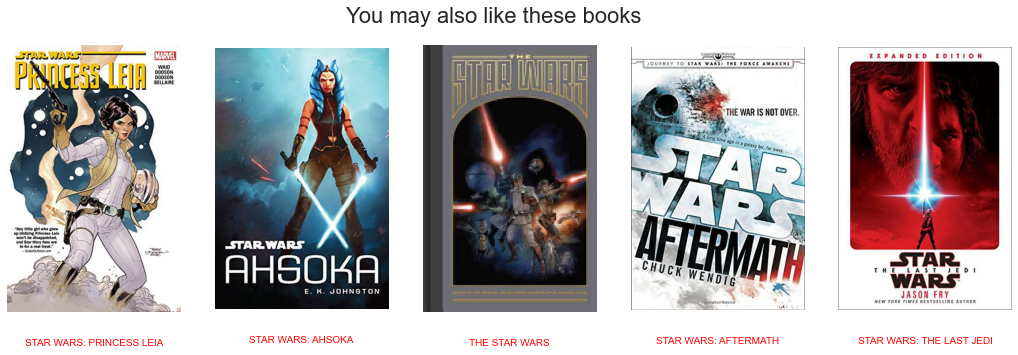

In [20]:
fig, axs = plt.subplots(1, 5,figsize=(18,5))
fig.suptitle('You may also like these books', size = 22)

for i, url in enumerate(recom_tf['book_image']):
    im = Image.open(requests.get(url, stream=True).raw)
    axs[i].imshow(im)
    axs[i].axis("off")
    axs[i].set_title("\n".join(wrap(recom_tf['sim_books'][i], 30)), y=-0.15, color='red', fontsize=10)
    fig.show()

<h2 style="color:#000000">2. Description Based Recommender System</h2>

<h3 style="color:#000000"><u>Count Vectorizer</u></h3>

In [21]:
vect = CountVectorizer(analyzer='word',ngram_range=(1,2),stop_words='english', min_df = 0.0005)
vect.fit(books_title['description'])
title_matrix = vect.transform(books_title['description'])
print(books_title['title'][5274])
recom_books = return_sim_books(5274,title_matrix,vect,top_n=5)
display(recom_books)

STAR WARS: PRINCESS LEIA


book_title  \
0  STAR WARS: PRINCESS LEIA   
1  STAR WARS: PRINCESS LEIA   
2  STAR WARS: PRINCESS LEIA   
3  STAR WARS: PRINCESS LEIA   
4  STAR WARS: PRINCESS LEIA   

                                           sim_books  \
0                           STAR WARS: PRINCESS LEIA   
1                                           GEEK DAD   
2  COOK THIS, NOT THAT! EASY AND AWESOME 350-CALO...   
3                                       GETTING MORE   
4                                   WINNER'S TRILOGY   

                              author    scores  \
0         Mark Waid and Terry Dodson  1.000000   
1                        Ken Denmead  0.258199   
2  David Zinczenko and Matt Goulding  0.258199   
3                     Stuart Diamond  0.258199   
4                     Marie Rutkoski  0.258199   

                                        words  \
0  [destruction , empire , home , leia , run]   
1                   [children , home , share]   
2               [home , improve , restaurant]   
3              [business , home , strategies]   
4                 [affections , empire , war]   

                                          book_image  
0  https://storage.googleapis.com/du-prd/books/im...  
1  https://storage.googleapis.com/du-prd/books/im...  
2  https://storage.googleapis.com/du-prd/books/im...  
3  https://storage.googleapis.com/du-prd/books/im...  
4  https://storage.googleapis.com/du-prd/books/im...

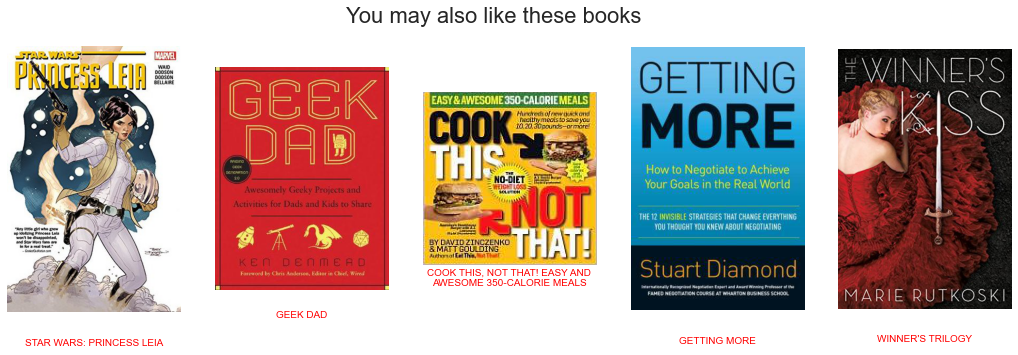

In [22]:
fig, axs = plt.subplots(1, 5,figsize=(18,5))
fig.suptitle('You may also like these books', size = 22)

for i, url in enumerate(recom_books['book_image']):
    im = Image.open(requests.get(url, stream=True).raw)
    axs[i].imshow(im)
    axs[i].axis("off")
    axs[i].set_title("\n".join(wrap(recom_books['sim_books'][i], 30)), y=-0.15, color='red', fontsize=10)
    fig.show()

<h3 style="color:#000000"><u>TF-IDF Vectorize</u></h3>

In [23]:
tf = TfidfVectorizer(analyzer = 'word', ngram_range = (1,2), min_df = 0.0005, stop_words = 'english')
tf.fit(books_title['description'])
title_matrix_tf = tf.transform(books_title['description'])
print(books_title['title'][5274])
recom_tf = return_sim_books(5274,title_matrix_tf,tf,top_n=5)
display(recom_tf)

STAR WARS: PRINCESS LEIA


book_title                   sim_books  \
0  STAR WARS: PRINCESS LEIA    STAR WARS: PRINCESS LEIA   
1  STAR WARS: PRINCESS LEIA        STAR WARS: BLOODLINE   
2  STAR WARS: PRINCESS LEIA            WINNER'S TRILOGY   
3  STAR WARS: PRINCESS LEIA       AN EMBER IN THE ASHES   
4  STAR WARS: PRINCESS LEIA  ABSOLUTE ALL-STAR SUPERMAN   

                             author    scores  \
0        Mark Waid and Terry Dodson  1.000000   
1                      Claudia Gray  0.313276   
2                    Marie Rutkoski  0.265822   
3                       Sabaa Tahir  0.240065   
4  Grant Morrison and Frank Quitely  0.235479   

                                               words  \
0         [destruction , empire , home , leia , run]   
1                  [leia , new , republic , senator]   
2                        [affections , empire , war]   
3                 [empire , fight , lives , martial]   
4  [12 , collects , couple , death , destruction ...   

                                          book_image  
0  https://storage.googleapis.com/du-prd/books/im...  
1  https://storage.googleapis.com/du-prd/books/im...  
2  https://storage.googleapis.com/du-prd/books/im...  
3  https://storage.googleapis.com/du-prd/books/im...  
4  https://storage.googleapis.com/du-prd/books/im...

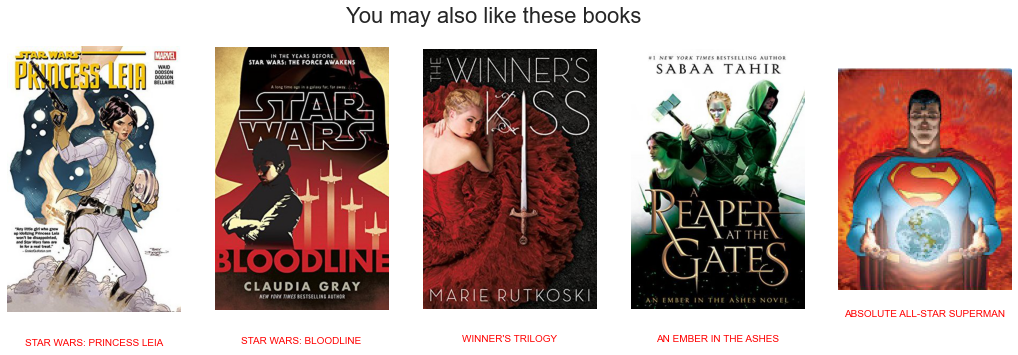

In [24]:
fig, axs = plt.subplots(1, 5,figsize=(18,5))
fig.suptitle('You may also like these books', size = 22)

for i, url in enumerate(recom_tf['book_image']):
    im = Image.open(requests.get(url, stream=True).raw)
    axs[i].imshow(im)
    axs[i].axis("off")
    axs[i].set_title("\n".join(wrap(recom_tf['sim_books'][i], 30)), y=-0.15, color='red', fontsize=10)
    fig.show()

<h2 style="color:#000000">3. Author Based Recommender System</h2>

<h3 style="color:#000000"><u>Count Vectorizer</u></h3>

In [25]:
vect = CountVectorizer(analyzer='word',ngram_range=(1,2),stop_words='english', min_df = 0.0001)
vect.fit(books_title['author'])
title_matrix = vect.transform(books_title['author'])
print(books_title['title'][5274])
recom_books = return_sim_books(5274,title_matrix,vect,top_n=5)
display(recom_books)

STAR WARS: PRINCESS LEIA


book_title                         sim_books  \
0  STAR WARS: PRINCESS LEIA          STAR WARS: PRINCESS LEIA   
1  STAR WARS: PRINCESS LEIA              IRREDEEMABLE, VOL. 7   
2  STAR WARS: PRINCESS LEIA  CAPTAIN AMERICA: MAN OUT OF TIME   
3  STAR WARS: PRINCESS LEIA                 DAREDEVIL, VOL. 1   
4  STAR WARS: PRINCESS LEIA              IRREDEEMABLE, VOL. 8   

                       author    scores  \
0  Mark Waid and Terry Dodson  1.000000   
1                   Mark Waid  0.654654   
2  Mark Waid and Jorge Molina  0.428571   
3  Mark Waid and Paolo Rivera  0.428571   
4  Mark Waid and Peter Krause  0.428571   

                                               words  \
0  [dodson , mark , mark waid , terry , terry dod...   
1                          [mark , mark waid , waid]   
2  [jorge , jorge molina , mark , mark waid , mol...   
3  [mark , mark waid , paolo , paolo rivera , riv...   
4  [krause , mark , mark waid , peter , peter kra...   

                                          book_image  
0  https://storage.googleapis.com/du-prd/books/im...  
1  https://storage.googleapis.com/du-prd/books/im...  
2  https://storage.googleapis.com/du-prd/books/im...  
3  https://storage.googleapis.com/du-prd/books/im...  
4  https://storage.googleapis.com/du-prd/books/im...

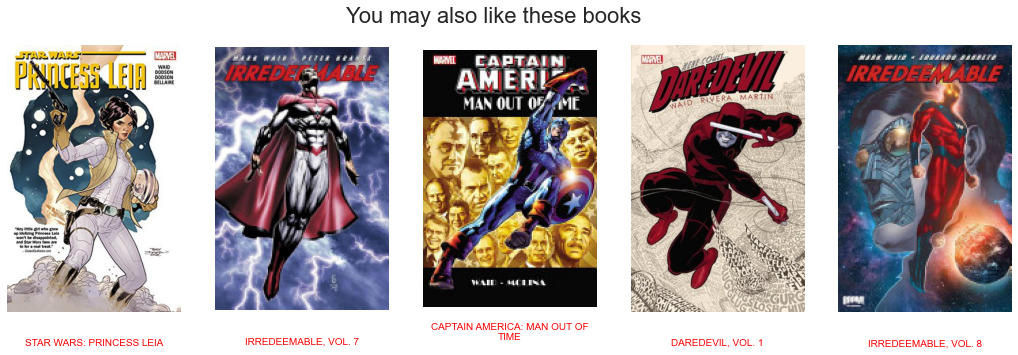

In [26]:
fig, axs = plt.subplots(1, 5,figsize=(18,5))
fig.suptitle('You may also like these books', size = 22)

for i, url in enumerate(recom_books['book_image']):
    im = Image.open(requests.get(url, stream=True).raw)
    axs[i].imshow(im)
    axs[i].axis("off")
    axs[i].set_title("\n".join(wrap(recom_books['sim_books'][i], 30)), y=-0.15, color='red', fontsize=10)
    fig.show()

<h3 style="color:#000000"><u>TF-IDF Vectorize</u></h3>

In [27]:
tf = TfidfVectorizer(analyzer = 'word', ngram_range = (1,2), min_df = 0.0001, stop_words = 'english')
tf.fit(books_title['author'])
title_matrix_tf = tf.transform(books_title['author'])
print(books_title['title'][5274])
recom_tf = return_sim_books(5274,title_matrix_tf,tf,top_n=5)
display(recom_tf)

STAR WARS: PRINCESS LEIA


book_title                         sim_books  \
0  STAR WARS: PRINCESS LEIA          STAR WARS: PRINCESS LEIA   
1  STAR WARS: PRINCESS LEIA              IRREDEEMABLE, VOL. 7   
2  STAR WARS: PRINCESS LEIA              IRREDEEMABLE, VOL. 8   
3  STAR WARS: PRINCESS LEIA  CAPTAIN AMERICA: MAN OUT OF TIME   
4  STAR WARS: PRINCESS LEIA                 DAREDEVIL, VOL. 1   

                       author    scores  \
0  Mark Waid and Terry Dodson  1.000000   
1                   Mark Waid  0.589099   
2  Mark Waid and Peter Krause  0.351206   
3  Mark Waid and Jorge Molina  0.335421   
4  Mark Waid and Paolo Rivera  0.334384   

                                               words  \
0  [dodson , mark , mark waid , terry , terry dod...   
1                          [mark , mark waid , waid]   
2  [krause , mark , mark waid , peter , peter kra...   
3  [jorge , jorge molina , mark , mark waid , mol...   
4  [mark , mark waid , paolo , paolo rivera , riv...   

                                          book_image  
0  https://storage.googleapis.com/du-prd/books/im...  
1  https://storage.googleapis.com/du-prd/books/im...  
2  https://storage.googleapis.com/du-prd/books/im...  
3  https://storage.googleapis.com/du-prd/books/im...  
4  https://storage.googleapis.com/du-prd/books/im...

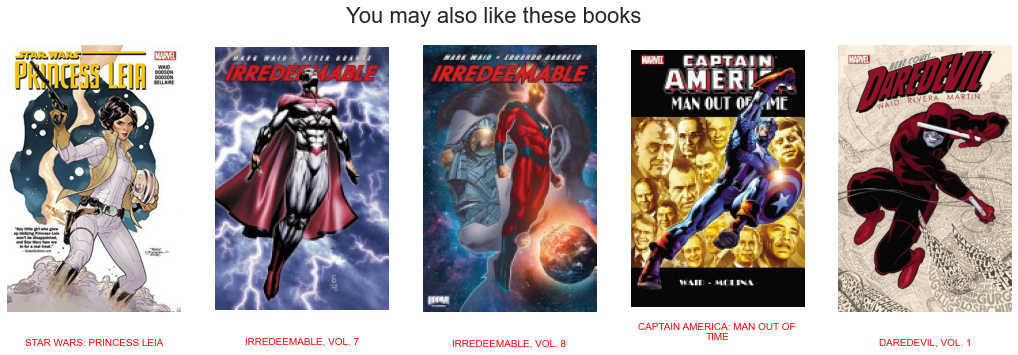

In [28]:
fig, axs = plt.subplots(1, 5,figsize=(18,5))
fig.suptitle('You may also like these books', size = 22)

for i, url in enumerate(recom_tf['book_image']):
    im = Image.open(requests.get(url, stream=True).raw)
    axs[i].imshow(im)
    axs[i].axis("off")
    axs[i].set_title("\n".join(wrap(recom_tf['sim_books'][i], 30)), y=-0.15, color='red', fontsize=10)
    fig.show()

<h1 style="color:#000000">VII. Results and Discussion</h1>

<span style="font-size: 20px"><b>Why should we use cosine similarity instead of $L_p$-norm?</b><p>&nbsp; </p> 

<span style="font-size: 16px">
<b>$L_p$-norm</b> is basically the distance between two vectors or points. The $L_p$-norm between two vectors $\vec v_1$ and $\vec v_2$ is
$$L_p(\vec v_1, \vec v_2) = \left(\sum_i \left| \vec v_{1_i} - \vec v_{2_i} \right|^p \right)^{1/p}$$

If $p=2$, it is the usual Euclidean distance. If $p=1$, it is known as the city block or Manhattan distance.

On the other hand, the **cosine similarity** between two vectors is related to the angle between them. The cosine similarity between two vectors $\vec v_1$ and $\vec v_2$ is
$$S_\text{cos}(\vec v_1, \vec v_2) = \frac{\vec v_1 \cdot \vec v_2}{\left|\left|\vec v_1\right|\right| \left|\left| \vec v_2 \right|\right|}.$$


If the vectors are nonnegative, which is the case for BoW vectors, its range is $[0,1]$ with 1 implying the two vectors are aligned (most similar) and 0 implying they are perpendicular (least similar).

The cosine similarity is beneficial because even if the two similar data objects are far apart by the Euclidean distance because of the size, they could still have a smaller angle between them. Smaller the angle, higher the similarity.

For recommender systems, one of the most commonly used similarity measures is cosine similarity.
</span>

<span style="font-size: 20px"><b>Which is better? Count Vectorizer or TF-IDF Vectorizer?</b>
<p>&nbsp; </p> 
<span style="font-size: 16px">

TF-IDF is in general better than Count Vectorizers because it not only focuses on the frequency of words present in the corpus but also provides the importance of the words. We can then remove the words that are less important for analysis, hence making the model building less complex by reducing the input dimensions.
    
</span>

<span style="font-size: 20px"><b>Why did we include the input book in the recommended list?</b>

<p>&nbsp; </p> 
<span style="font-size: 16px">
    
For the sake of visualization, we included the input notebook in the recommended list even though we can easily remove it and replace it with the actual similar results. Displaying the input book makes it easier to compare and choose from the list of recommended books.

</span>

<span style="font-size: 20px"><b>Can we adjust the sensitivity of information retrieval?</b>
    
<p>&nbsp; </p> 
<span style="font-size: 16px">
    
Yes. We can also adjust the sensitivity of information retrieval by tuning the min_df and max_df parameter of both the Count Vectorizer and Tf-Idf Vectorizer.

</span>

<h1 style="color:#000000">VIII. Conclusion</h1>

<span style="font-size: 16px">

Recommending books can be based on several things ranging from the book title, and description, to the author. It does not have to be constrained this way as you can always do some recommendations based on a publisher or a set of tags. An even more robust methodology would be to simply combine the context of all previously mentioned basis for recommendation and look for the k nearest similarities.
    
If you're a reader looking to read a book that probably stands in the same parallel setting as the book you have previously read, then a title-based and author-based recommender is the way to go as it simply recommends books based on a similar style of work. Just like the examples, using the title-based recommender off a previously read Starwars book will also give you the next best Starwars book to complement what you have just read.
    
The description-based recommender system on the other hand is unique as it recommends books of similar description. Sometimes, the context of the description is not taken into consideration as the vectorizer only takes words at face value. However, it is not to say that the recommendations are not similar. It should still be similar under a singular theme.
    
</span>

<h1 style="color:#000000">IX. Recommendation</h1>

<span style="font-size: 16px">
    
To take things a step further, the proponents of this project recommend building a more robust recommender by doing a custom recommender. One way to do it would be to combine all of the features like author, description, and title into a single vector and look for similar results. Another way, which the authors strongly recommend is by changing how the recommender system works by dynamically changing the search filtering technique depending on the factors that drive a user. 
    
Another option that one can explore is using other types of distance measurements. Although it might be argued that cosine similarity is the best distance measure for a book recommender system, other distances could also work in this context. The most common similarity measures among book recommender systems are cosine, Euclidian, and Pearson.

Some however use the Adjusted Cosine Vector Similarity function to compute similarity among book ratings to recommend books, to take into account that users have different rating schemes.
</span>

<h1 style="color:#000000">X. References</h1>

<sup>1</sup> The Phenomenon and Psychology of a Book Hangover.Barnett.https://bookriot.com/psychology-of-a-book-hangover/#:~:text=A%20%E2%80%9Cbook%20hangover%E2%80%9D%20is%20the,the%20atmosphere%20of%20the%20novel.

- FAQ – New York Times developer.nytimes.com https://developer.nytimes.com/faq#a1

- Overview - New York Times. developer.nytimes.com 


In [3]:
engine = create_engine('sqlite:////mnt/processed/private/msds2023/lt9/karaoke.db')
# engine = create_engine('sqlite:///karaoke.db')
df_videos = pd.read_sql_table('df_videos', engine)
df_views = pd.read_sql_table('df_views', engine)
df_comments = pd.read_sql_table('df_comments', engine)

In [53]:
df_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76148 entries, 0 to 76147
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   videoId                76148 non-null  object
 1   textDisplay            76148 non-null  object
 2   textOriginal           76148 non-null  object
 3   authorDisplayName      76148 non-null  object
 4   authorProfileImageUrl  76148 non-null  object
 5   authorChannelUrl       76148 non-null  object
 6   canRate                76148 non-null  int64 
 7   viewerRating           76148 non-null  object
 8   likeCount              76148 non-null  int64 
 9   publishedAt            76148 non-null  object
 10  updatedAt              76148 non-null  object
 11  value                  76141 non-null  object
 12  moderationStatus       667 non-null    object
dtypes: int64(2), object(11)
memory usage: 7.6+ MB


In [70]:
df_comments.head(10)

videoId                                     textDisplay  \
0  U509W5j8eXo       Request: Panaginip By Mikee Quintos plsss   
1  U509W5j8eXo  Pa request naman po ng Magda by Marko Rudio. 🙏   
2  U509W5j8eXo                         Me encanta,  nice ✨️🎵👍🏼   
3  U509W5j8eXo                                               😍   
4  U509W5j8eXo                   👆 - BEAUTIFUL GIRLS HERE 😍🔥j😘   
5  U509W5j8eXo                                             ❤❤❤   
6  ft95vO1dsqA        sarap kantahin...<br>ng mag sweatheart..   
7  ft95vO1dsqA                     GABAY BY KZ TANDINGAN PLS 🥺   
8  ft95vO1dsqA                                    Good morning   
9  ft95vO1dsqA                                    Beautiful 👍🏼   

                                     textOriginal     authorDisplayName  \
0       Request: Panaginip By Mikee Quintos plsss        Sofia Celestia   
1  Pa request naman po ng Magda by Marko Rudio. 🙏         Sammy Petilla   
2                         Me encanta,  nice ✨️🎵👍🏼              Mygue CH   
3                                               😍        Lawrence Orido   
4                   👆 - BEAUTIFUL GIRLS HERE 😍🔥j😘          𝗚𝗜𝗥𝗟𝗦𝟭𝟴.𝗦𝗜𝗧𝗘   
5                                             ❤❤❤         Shella Abella   
6          sarap kantahin...\nng mag sweatheart..  Paulino Efren Endaya   
7                     GABAY BY KZ TANDINGAN PLS 🥺         lovesu mizuki   
8                                    Good morning             nicz Tyme   
9                                    Beautiful 👍🏼              Mygue CH   

                               authorProfileImageUrl  \
0  https://yt3.ggpht.com/ytc/AMLnZu-fvnmFUdDtedlO...   
1  https://yt3.ggpht.com/ytc/AMLnZu_v0ygALkPyoHDc...   
2  https://yt3.ggpht.com/k5n3RUSzt1674vA9A5CftNOm...   
3  https://yt3.ggpht.com/ytc/AMLnZu9h2GzmSIixTdwO...   
4  https://yt3.ggpht.com/ytc/AMLnZu_ktPStCEvF51nI...   
5  https://yt3.ggpht.com/87NZenkrtKScfV5ir8Hmdm4s...   
6  https://yt3.ggpht.com/ytc/AMLnZu_MIHxC-xVuoGxM...   
7  https://yt3.ggpht.com/ytc/AMLnZu_YD3zLPlcKBWp_...   
8  https://yt3.ggpht.com/ytc/AMLnZu8OO58VnXQNYXQn...   
9  https://yt3.ggpht.com/k5n3RUSzt1674vA9A5CftNOm...   

                                    authorChannelUrl  canRate viewerRating  \
0  http://www.youtube.com/channel/UCME6mzqb_ZdYvm...        1         none   
1  http://www.youtube.com/channel/UC8B6FqO6y0mWvx...        1         none   
2  http://www.youtube.com/channel/UCkZPqUo7J7Se1g...        1         none   
3  http://www.youtube.com/channel/UCMJlxRsEAEUiRI...        1         none   
4  http://www.youtube.com/channel/UClotXSOe977rzg...        1         none   
5  http://www.youtube.com/channel/UCAYqAQfydFxFe4...        1         none   
6  http://www.youtube.com/channel/UCg7o_mYRFfzfDj...        1         none   
7  http://www.youtube.com/channel/UCZOPnsmZKrHT_J...        1         none   
8  http://www.youtube.com/channel/UC_kSYQ3R5tZDt7...        1         none   
9  http://www.youtube.com/channel/UCkZPqUo7J7Se1g...        1         none   

   likeCount           publishedAt             updatedAt  \
0          0  2022-11-24T05:22:40Z  2022-11-24T05:22:40Z   
1          0  2022-11-19T12:37:18Z  2022-11-19T12:37:18Z   
2          0  2022-11-17T07:17:31Z  2022-11-17T07:17:31Z   
3          0  2022-11-17T04:43:38Z  2022-11-17T04:43:38Z   
4          0  2022-11-17T04:16:58Z  2022-11-17T04:16:58Z   
5          0  2022-11-17T04:12:49Z  2022-11-17T04:12:49Z   
6          0  2022-11-23T08:25:05Z  2022-11-23T08:25:05Z   
7          0  2022-11-20T09:32:55Z  2022-11-20T09:32:55Z   
8          0  2022-11-16T22:12:08Z  2022-11-16T22:12:08Z   
9          1  2022-11-16T10:10:21Z  2022-11-16T10:10:21Z   

                      value moderationStatus  
0                      None             None  
1  UC8B6FqO6y0mWvxjxRb5hENg             None  
2  UCkZPqUo7J7Se1g_9Lav9nIw             None  
3  UCMJlxRsEAEUiRIgK3SI4-TQ             None  
4  UClotXSOe977rzgeDAxBnRog             None  
5  UCAYqAQfydFxFe4HlTjoQ40Q        

In [71]:
type(df_comments['value'][1])

str